# Loading and Cleaning Data

First we read our csv file with all scores into a dataframe.

In [2]:
import pandas as pd
import numpy as np

all_scores = pd.read_csv('cfb_box-scores_2002-2024.csv')
all_scores.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


Now we want to extract the names of all of the conferences, so we can filter out non-Power 5 games. 

In [3]:
# Get unique values from conf_home and conf_away
home_confs = all_scores["conf_home"].unique()
away_confs = all_scores["conf_away"].unique()

# Combine them into one set to get all unique conferences
all_confs = set(home_confs).union(set(away_confs))

# Display the result
all_confs

{'aac',
 'acc',
 'big-east',
 'big10',
 'big12',
 'cusa',
 'ind',
 'mac',
 'mwc',
 nan,
 'pac12',
 'sec',
 'sun-belt',
 'wac'}

Now we create a new dataframe with only power 5 games.

In [4]:
p5 = {"sec", "acc", "big10", "big12", "pac12"}
p5_scores = all_scores[
    all_scores["conf_home"].isin(p5) &
    all_scores["conf_away"].isin(p5)]

p5_scores.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN
5,2002,1.0,2002-08-24,8:30 PM,regular,Florida State,Iowa State,3.0,NaN,acc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55132.0,NaN
22,2002,2.0,2002-08-31,12:00 PM,regular,Washington,Michigan,11.0,13.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111491.0,NaN
25,2002,2.0,2002-08-31,12:30 PM,regular,Kansas,Iowa State,NaN,NaN,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40026.0,NaN


# Feature Engineering

Let's add some features that could potentially be important. 

In [5]:
import numpy as np
# Ensure p5_scores is a copy so we avoid SettingWithCopyWarning
p5_scores = p5_scores.copy()

# Compute penalty rate safely (yards per penalty), avoid divide-by-zero by replacing 0s with NaN
p5_scores["penalty_rate_home"] = p5_scores["pen_yards_home"] / p5_scores["pen_num_home"].replace(0, np.nan)
p5_scores["penalty_rate_away"] = p5_scores["pen_yards_away"] / p5_scores["pen_num_away"].replace(0, np.nan)

# Fill NaNs with 0 for now (TODO: consider better imputation strategy like mean or median)
p5_scores["penalty_rate_home"] = p5_scores["penalty_rate_home"].fillna(0)
p5_scores["penalty_rate_away"] = p5_scores["penalty_rate_away"].fillna(0)


In [6]:
#Turnover Margin (fumbles + interceptions)
p5_scores["turnovers_home"] = p5_scores["fum_home"] + p5_scores["int_home"]
p5_scores["turnovers_away"] = p5_scores["fum_away"] + p5_scores["int_away"]
p5_scores["turnover_margin"] = p5_scores["turnovers_away"] - p5_scores["turnovers_home"]

In [7]:

#Passing Efficiency (yards per attempt)
p5_scores["pass_eff_home"] = p5_scores["pass_yards_home"] / p5_scores["pass_att_home"].replace(0, np.nan)
p5_scores["pass_eff_away"] = p5_scores["pass_yards_away"] / p5_scores["pass_att_away"].replace(0, np.nan)
p5_scores["pass_eff_home"] = p5_scores["pass_eff_home"].fillna(0)
p5_scores["pass_eff_away"] = p5_scores["pass_eff_away"].fillna(0)
# TODO: review whether 0 is appropriate for pass efficiency fill

In [8]:

#Third Down Conversion %
p5_scores["third_down_pct_home"] = p5_scores["third_down_comp_home"] / p5_scores["third_down_att_home"].replace(0, np.nan)
p5_scores["third_down_pct_away"] = p5_scores["third_down_comp_away"] / p5_scores["third_down_att_away"].replace(0, np.nan)
p5_scores["third_down_pct_home"] = p5_scores["third_down_pct_home"].fillna(0)
p5_scores["third_down_pct_away"] = p5_scores["third_down_pct_away"].fillna(0)
# TODO: explore whether zero conversion rate is valid when no attempts


In [9]:
# point differential (target variable)
p5_scores["point_diff"] = p5_scores["score_home"] / p5_scores["score_away"].replace(0, np.nan)

# Selecting Features and Target Variable

In [10]:
p5_scores.columns.tolist()

['season',
 'week',
 'date',
 'time_et',
 'game_type',
 'away',
 'home',
 'rank_away',
 'rank_home',
 'conf_away',
 'conf_home',
 'neutral',
 'score_away',
 'score_home',
 'q1_away',
 'q2_away',
 'q3_away',
 'q4_away',
 'ot_away',
 'q1_home',
 'q2_home',
 'q3_home',
 'q4_home',
 'ot_home',
 'first_downs_away',
 'first_downs_home',
 'third_down_comp_away',
 'third_down_att_away',
 'third_down_comp_home',
 'third_down_att_home',
 'fourth_down_comp_away',
 'fourth_down_att_away',
 'fourth_down_comp_home',
 'fourth_down_att_home',
 'pass_comp_away',
 'pass_att_away',
 'pass_yards_away',
 'pass_comp_home',
 'pass_att_home',
 'pass_yards_home',
 'rush_att_away',
 'rush_yards_away',
 'rush_att_home',
 'rush_yards_home',
 'total_yards_away',
 'total_yards_home',
 'fum_away',
 'fum_home',
 'int_away',
 'int_home',
 'pen_num_away',
 'pen_yards_away',
 'pen_num_home',
 'pen_yards_home',
 'possession_away',
 'possession_home',
 'attendance',
 'tv',
 'penalty_rate_home',
 'penalty_rate_away',
 'tur

In [11]:
# Core features for predicting point differential
features = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_eff_home', 'pass_eff_away',
    'third_down_pct_home', 'third_down_pct_away',
    'penalty_rate_home', 'penalty_rate_away',
    'pen_yards_home', 'pen_yards_away',
    'turnovers_home', 'turnovers_away', 'turnover_margin',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away',
    'rank_home', 'rank_away',
    'neutral'
]

spread = ['point_diff']

# Training and Testing a Basic Linear Regression Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Filter by season on the full dataset (not yet cleaned)
train_df_raw = p5_scores[p5_scores['season'] < 2024]
test_df_raw = p5_scores[p5_scores['season'] >= 2024]

# Step 2: Select features and target, drop missing values
train_df = train_df_raw[features + ['point_diff']].dropna()
test_df = test_df_raw[features + ['point_diff']].dropna()

# Step 3: Separate X and y
X_train = train_df[features]
y_train = train_df['point_diff']
X_test = test_df[features]
y_test = test_df['point_diff']

# Step 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 1.38
MAE: 0.75


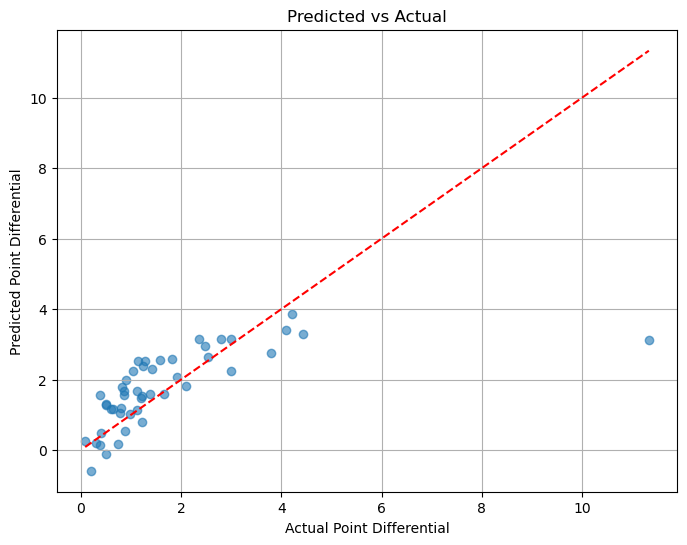

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Point Differential")
plt.ylabel("Predicted Point Differential")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


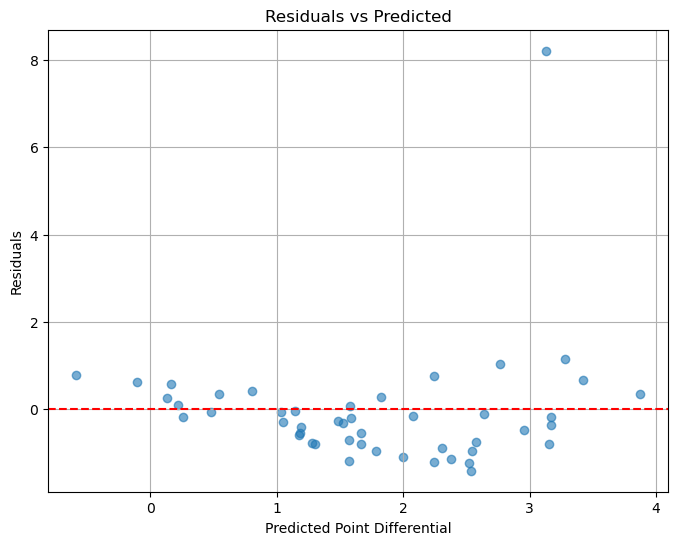

In [16]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Point Differential")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()


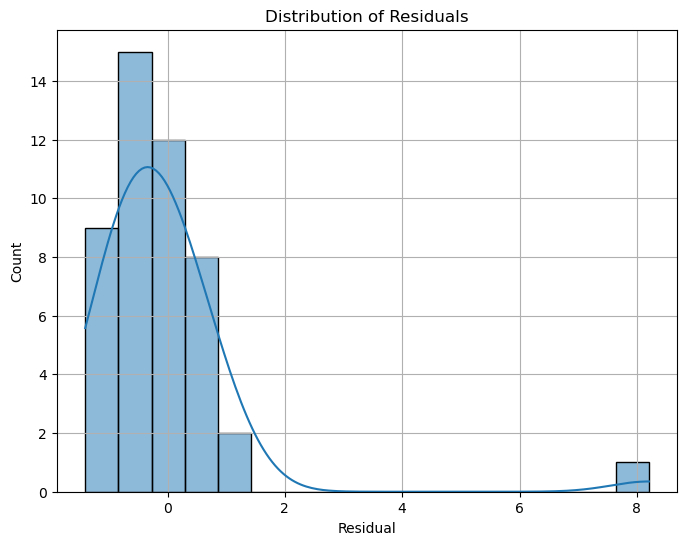

In [17]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.show()


In [20]:
%load_ext autoreload
%autoreload 2
from cfb import FootballNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [23]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [24]:
model = FootballNet(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
def train(model, loader, optimizer, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")


In [26]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            preds.append(outputs)
            targets.append(y_batch)
    y_pred = torch.cat(preds).numpy()
    y_true = torch.cat(targets).numpy()
    return y_true, y_pred


In [27]:
train(model, train_loader, optimizer, criterion, epochs=50)
y_true, y_pred = evaluate(model, test_loader)


Epoch 1/50, Loss: 5.3763
Epoch 2/50, Loss: 3.5536
Epoch 3/50, Loss: 2.6549
Epoch 4/50, Loss: 2.3152
Epoch 5/50, Loss: 2.3090
Epoch 6/50, Loss: 2.1357
Epoch 7/50, Loss: 2.2683
Epoch 8/50, Loss: 2.0506
Epoch 9/50, Loss: 2.1209
Epoch 10/50, Loss: 1.9818
Epoch 11/50, Loss: 2.0643
Epoch 12/50, Loss: 1.9645
Epoch 13/50, Loss: 1.8457
Epoch 14/50, Loss: 1.9650
Epoch 15/50, Loss: 1.8924
Epoch 16/50, Loss: 1.9200
Epoch 17/50, Loss: 1.9743
Epoch 18/50, Loss: 2.0412
Epoch 19/50, Loss: 1.6322
Epoch 20/50, Loss: 1.7379
Epoch 21/50, Loss: 1.8238
Epoch 22/50, Loss: 1.6965
Epoch 23/50, Loss: 1.7549
Epoch 24/50, Loss: 1.6541
Epoch 25/50, Loss: 1.7442
Epoch 26/50, Loss: 1.6279
Epoch 27/50, Loss: 1.5932
Epoch 28/50, Loss: 1.4788
Epoch 29/50, Loss: 1.5725
Epoch 30/50, Loss: 1.5088
Epoch 31/50, Loss: 1.3791
Epoch 32/50, Loss: 1.4826
Epoch 33/50, Loss: 1.3900
Epoch 34/50, Loss: 1.3463
Epoch 35/50, Loss: 1.3883
Epoch 36/50, Loss: 1.6020
Epoch 37/50, Loss: 1.4645
Epoch 38/50, Loss: 1.2365
Epoch 39/50, Loss: 1.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")

In [29]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Point Differential")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()

In [30]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Point Differential")
    plt.ylabel("Predicted Point Differential")
    plt.title("Predicted vs Actual")
    plt.show()

RMSE: 1.32
MAE : 0.57


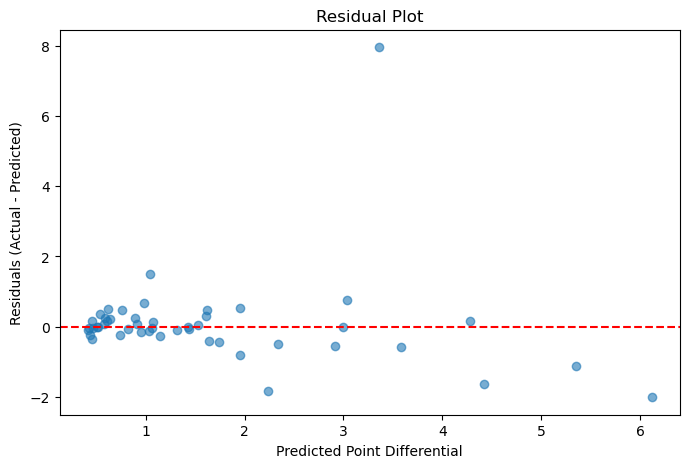

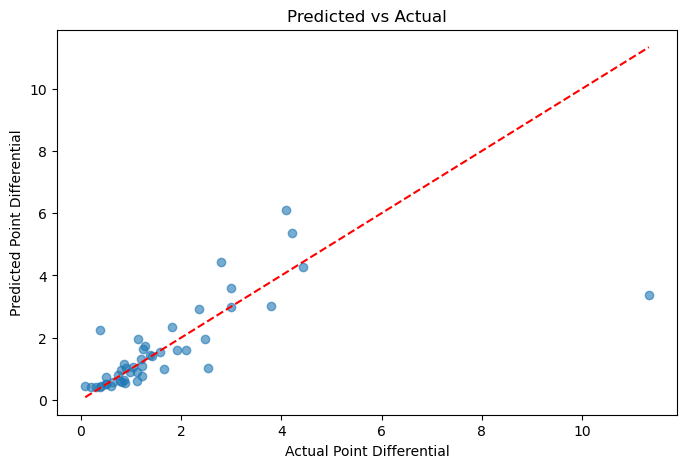

In [32]:
y_true, y_pred = evaluate(model, test_loader)
print_metrics(y_true, y_pred)
plot_residuals(y_true, y_pred)
plot_predictions(y_true, y_pred)

Linear Baseline had RMSE: 1.38 and MAE: 0.75. Deep learning had RMSE: 1.32 and MAE : 0.57. This is an improvement. 